# crack 이미지로만 학습된 모델의 분류 성능 확인
* 엄밀히 말하면 분류는 아니지만, 일종의 성능테스트로 사용한다.
* 오분류의 정의는 crack 사진에서 crack을 찾지 못하거나, noncrack사진에서 crack을 찾는 경우다.
* 오분류한 대상의 비율을 확인함으로써, yolov5 detector의 대략적 성능을 확인한다.

In [24]:
import os
from glob import glob


def get_detections(detect_result_dir, all):
    BASE = os.path.dirname(os.getcwd())
    DETECT_BASE = os.path.join(BASE,'yolov5','runs','detect')
    
    if all: # detect 된것, 안된것 다 이미지경로로 리턴
        return glob(os.path.join(DETECT_BASE, detect_result_dir, '*.jpg'))
    else:  # detect된 사진 이름만 리턴
        detections = glob(os.path.join(DETECT_BASE, detect_result_dir, 'labels', '*.txt'))
        return list(map(lambda x:os.path.basename(x).split('.')[0],detections)) 

def get_raw_images(category):
    BASE = os.path.dirname(os.getcwd())
    TEST_IMAGE_BASE = os.path.join(BASE, 'dataset', 'test_images', category)
    
    return glob(os.path.join(TEST_IMAGE_BASE, '*.jpg')) # 이미지 경로를 리턴

    
def mispredictions(detection_result_dirname, target='crack'):
    
    crack_test_all = get_raw_images(category='crack')
    noncrack_bbox_all = get_detections(detect_result_dir=detection_result_dirname, all=True)
    
    if target == 'crack':
        # crack일 때 detection 못한다면 detection 하지 못한 raw 이미지 경로 리스트를 리턴
        
        # detect 한 이미지 파일 이름 가져옴
        crack_detections = get_detections(detect_result_dir=detection_result_dirname, all=False)
        
        # 전체 테스트 이미지 중 detect한 이미지를 제외한 나머지 이미지 파일 이름 구함
        crack_not_detected = []
        for file in crack_test_all:
            file_name = os.path.basename(file).split('.')[0]
            if file_name not in crack_detected:
                crack_not_detected.append(file)
        
        # detection 실패한 raw 이미지 경로 리스트 리턴
        return crack_not_detected
        
        
    elif target == 'noncrack':
        # non crack일 때 detection 한 bbox 포함 이미지 경로 리스트를 리턴
        
        # detect 성공한 이미지 파일 이름 가져옴
        noncrack_detections = get_detections(detect_result_dir=detection_result_dirname, all=False)
        
        # non crack의 전체 bbox 이미지 중 detect 성공 이미지 리스트에 없으면 제거
        noncrack_bbox = []
        
        for file in noncrack_bbox_all:
            file_name = os.path.basename(file).split('.')[0]
            if file_name in noncrack_detections:
                noncrack_bbox.append(file)
        
        # detection 해버린 non crack bbox 이미지 경로 리스트 리턴
        return noncrack_bbox
        

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def draw_confusion(TP, TN, FP, FN):
    LABELS = ['CRACK','NONCRACK']
    
    array = np.array([[TP, FN],[FP, TN]])
    
    total, _ = array.sum(axis=1)
    array = array/total  # NORMALIZED
    
    df = pd.DataFrame(array, columns=LABELS, index=LABELS)
    
    plt.figure(figsize=(10,7))
    plt.title('confusion matrix', fontsize=20)
    sns.heatmap(df, annot=True, cmap="YlGnBu")

    # xlabe을 heatmap 그리기 전에 선언하면 안먹는다;;
    plt.xlabel('Prediction', fontsize=20)
    plt.ylabel('Ground Truth', fontsize=20)
    plt.show()


In [60]:
from shutil import copyfile

def save_misimages(sources, destination, category='crack'):
    BASE = os.getcwd()
    parent = os.path.join(BASE, destination)
    child = os.path.join(parent, category)
    
    # 상위 폴더 
    if not os.path.exists(parent):
        os.mkdir(parent)
        
    # 하위폴더
    if not os.path.exists(child):
        os.mkdir(child)
    
    for src in sources:
        file_name = os.path.basename(src).split('.')[0]
        copyfile(src, os.path.join(child, file_name+'.jpg'))

# confidence threshold : 25%

## non crack 중에서 detected

In [76]:
noncrack_mis = mispredictions(detection_result_dirname='noncrack_25', target='noncrack')

In [77]:
len(noncrack_mis)

147

## crack 중에서 not detected

In [78]:
crack_mis = mispredictions(detection_result_dirname='crack_25', target='crack')

In [79]:
crack_mis

['/home/piai/Desktop/crack/dataset/test_images/crack/09419.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/19211_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/13825_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/11250_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/11044_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/09721.jpg']

### non crack 중 detected 는 bbox image를 저장

In [80]:
save_misimages(sources=crack_mis, destination='25', category='crack')

In [81]:
save_misimages(sources=noncrack_mis, destination='25', category='noncrack')

# 결과 confusion matrix

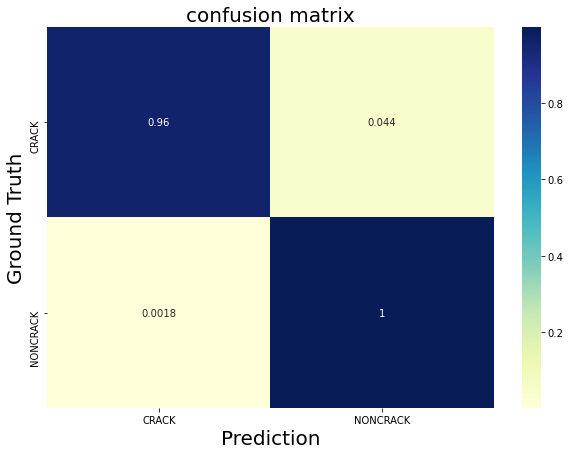

In [67]:
TOTAL = len(get_raw_images(category='crack'))

FP = len(crack_mis)
FN = len(noncrack_mis)
TP = TOTAL - FN
TN = TOTAL - FP

draw_confusion(TP, TN, FP, FN)

# confidence threshold : 75

## detection 결과 확인
* confidence 25 일 때에 비해 crack mis는 그대로인 반면(mis 이미지도 그대로) noncrack miss가 큰 폭으로 줄었다(147 -> 2)

In [82]:
noncrack_mis = mispredictions(detection_result_dirname='noncrack_75', target='noncrack')
crack_mis = mispredictions(detection_result_dirname='crack_75', target='crack')

In [83]:
noncrack_mis

['/home/piai/Desktop/crack/yolov5/runs/detect/noncrack_75/13694.jpg',
 '/home/piai/Desktop/crack/yolov5/runs/detect/noncrack_75/07718.jpg']

In [84]:
crack_mis

['/home/piai/Desktop/crack/dataset/test_images/crack/09419.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/19211_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/13825_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/11250_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/11044_1.jpg',
 '/home/piai/Desktop/crack/dataset/test_images/crack/09721.jpg']

## 결과 이미지 저장

In [85]:
save_misimages(sources=crack_mis, destination='75', category='crack')
save_misimages(sources=noncrack_mis, destination='75', category='noncrack')

## confusion matrix

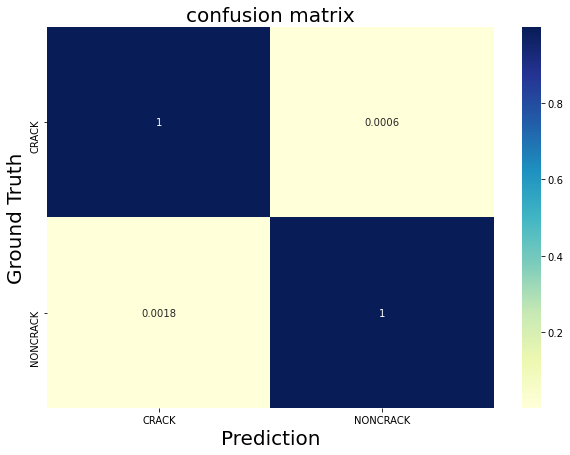

In [86]:
TOTAL = len(get_raw_images(category='crack'))

FP = len(crack_mis)
FN = len(noncrack_mis)
TP = TOTAL - FN
TN = TOTAL - FP

draw_confusion(TP, TN, FP, FN)